In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from pingouin import partial_corr

from mechir.data import CatDataCollator, DotDataCollator, MechDataset

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from pyserini.search.lucene import LuceneSearcher
from pyserini.index.lucene import IndexReader

from collections import Counter
import math

Matplotlib created a temporary cache directory at /scratch_local/esx208-1114693/tmp/matplotlib-2zpnl_li because the default path (/scratch_local/eickhoff/esx208/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
Fontconfig error: Cannot load default config file: No such file: (null)
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories
Fontconfig error: No writable cache directories


In [6]:
tokenizer = AutoTokenizer.from_pretrained('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')

FORMATTED_MODEL_NAME = 'sebastian-hofstaetter-distilbert-dot-tas_b-b256-msmarco'
MODEL_TYPE = 'bi'
PERTURBATION = 'STMC1'
K = 4000
BATCH_SIZE = 100

data_path = f'./data/patching_unnormalised/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head_all.npy'
topk_file = f"./data/topk_my/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv"
doc_metrics_file = '/mnt/qb/work/eickhoff/esx208/MechIR/data/TFC1-data_w_metrics.tsv'
query_metrics_file = '/mnt/qb/work/eickhoff/esx208/MechIR/data/TREC-queries-data_w_metrics.tsv'

patching_results = np.load(data_path)
original_scores = np.load(data_path.replace('head_all', 'head_all_original_scores'))
perturbed_scores = np.load(data_path.replace('head_all', 'head_all_perturbed_scores'))
all_data_pd = pd.read_csv(topk_file, sep='\t')
all_data_pd['injected_term'] = all_data_pd['perturbed_text'].apply(lambda x: x.rsplit(' ', 1)[1])
doc_metrics_data = pd.read_csv(doc_metrics_file, sep='\t').drop_duplicates(subset=['docno'])
query_metrics_data = pd.read_csv(query_metrics_file, sep='\t').drop_duplicates(subset=['query_id'])
all_data_pd = all_data_pd.merge(doc_metrics_data, on=['docno'], suffixes=('', '_doc'))
all_data_pd = all_data_pd.merge(query_metrics_data, left_on=['qid'], right_on=['query_id'], suffixes=('', '_query'))

In [8]:
all_data_pd

,qid,query,docno,text,relevance,perturbed,perturbed_score,inj_term,synonym,rank,...,doc_length_query,english_probability_query,flesch_reading_ease_query,flesch_kincaid_grade_query,gunning_fog_query,smog_index_query,coleman_liau_index_query,automated_readability_index_query,dale_chall_readability_score_query,gpt2_perplexity_query
0,405717,is cdg airport in main paris,7442727,Some search phrases often used to find this si...,0,True,101.805160,airport,paris airport,128,...,6,0.999995,99.23,0.9,2.40,0.0,1.38,-0.5,11.83,327.325653
1,1127540,meaning of shebang,2176972,In a summary you can face following things in ...,0,True,90.246040,shebang,shebang line,103,...,3,0.857143,59.97,5.6,1.20,0.0,5.35,5.2,14.31,57.735607
2,1127540,meaning of shebang,8132731,"array, assemblage, band, bank, batch, battery,...",0,True,90.757930,shebang,shebang line,95,...,3,0.857143,59.97,5.6,1.20,0.0,5.35,5.2,14.31,57.735607
3,1122767,what amino produces carnitine,2113726,Side effects of zolfresh tablet 5mg. Premium Q...,0,True,85.670250,carnitine,acetylcarnitine,336,...,4,0.999995,50.50,7.2,11.60,0.0,14.50,11.2,15.68,243.384995
4,1127540,meaning of shebang,2877830,1 Any shell can be used for writing a shell sc...,0,True,85.467650,shebang,shebang line,217,...,3,0.857143,59.97,5.6,1.20,0.0,5.35,5.2,14.31,57.735607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,451602,medicare's definition of mechanical ventilation,6587791,CPAP is the abbreviation for continuous positi...,3,True,90.047940,of,belonging,318,...,5,0.999996,-52.05,21.8,26.00,0.0,27.00,21.6,16.52,52.103062
3996,877809,what metal are hip replacements made of,6269999,Titanium is a component of joint replacement p...,3,True,97.898125,hip,pelvic,134,...,7,0.999997,81.29,3.7,8.51,0.0,7.37,4.3,6.24,133.643555
3997,183378,exons definition biology,8570261,DNA is composed of sections known as exons and...,3,True,98.231950,exons,introns,117,...,3,0.714282,-75.40,24.5,27.87,0.0,16.95,14.6,19.58,2744.250488
3998,168216,does legionella pneumophila cause pneumonia,13499,"Streptococcus pneumoniae, a type of bacteria, ...",3,True,110.027270,pneumonia,infection,13,...,5,0.000000,15.64,12.3,26.00,0.0,23.52,17.8,13.36,97.982094


In [9]:
searcher = LuceneSearcher.from_prebuilt_index('msmarco-v1-passage-slim')
reader = IndexReader.from_prebuilt_index('msmarco-v1-passage-slim')

Feb 03, 2025 2:35:37 PM org.apache.lucene.store.MMapDirectory lookupProvider


In [10]:
def get_tfidf(text, reader):
    terms = text.split()
    tf = Counter(terms)
    num_docs = reader.stats()['documents']
    
    tfidf_scores = dict()
    for term, term_count in tf.items():
        try:
            df = reader.get_term_counts(term)[0]
        except:
            df = 0
        if df > 0:
            tf = term_count / len(terms)
            idf = math.log(num_docs / df)
            tfidf_scores[term] = tf * idf
        else:
            tfidf_scores[term] = 0
    return tfidf_scores

def get_tf_injected_term(text, term):
    terms = text.split()
    tf = Counter(terms)
    if term in tf:
        return tf[term]
    else:
        return 0

def get_tfidf_injected_term(text, term, reader):
    tfidf_scores = get_tfidf(text, reader)
    if term in tfidf_scores:
        return tfidf_scores[term]
    else:
        return 0

In [11]:
all_data_pd['idf_injected_term'] = all_data_pd['injected_term'].apply(lambda x: get_tfidf(x, reader)[x])
all_data_pd['tf_injected_term'] = all_data_pd.apply(lambda x: get_tf_injected_term(x['text_tokenized'], x['injected_term']), axis=1)
all_data_pd['tfidf_injected_term'] = all_data_pd.apply(lambda x: get_tfidf_injected_term(x['text_tokenized'], x['injected_term'], reader), axis=1)

In [12]:
def add_target_metrics(data, patching_results, original_scores, perturbed_scores):
    data['original_score'] = original_scores
    data['perturbed_score'] = perturbed_scores

    score_difference = perturbed_scores - original_scores
    data['score_delta'] = score_difference
    
    patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
    patching_results_normalised_square = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
    patching_effect_normalised_clip = np.clip(patching_results_normalised, -1, 1)
    
    data['patching_effect_std'] = np.std(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-1,-2))
    data['patching_effect_absolute_mean'] = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-1,-2))
    data['patching_effect_normalised_std'] = np.std(patching_results_normalised, axis=(-1,-2))
    data['patching_effect_normalised_absolute_mean'] = np.mean(np.abs(patching_results_normalised), axis=(-1,-2))
    data['patching_effect_normalised_square_std'] = np.std(patching_results_normalised_square, axis=(-1,-2))
    data['patching_effect_normalised_square_absolute_mean'] = np.mean(np.abs(patching_results_normalised_square), axis=(-1,-2))
    data['patching_effect_normalised_clip_std'] = np.std(patching_effect_normalised_clip, axis=(-1,-2))
    data['patching_effect_normalised_clip_absolute_mean'] = np.mean(np.abs(patching_effect_normalised_clip), axis=(-1,-2))
    
    return data

In [13]:
add_target_metrics(all_data_pd, patching_results, original_scores, perturbed_scores);

In [14]:
all_data_pd

,qid,query,docno,text,relevance,perturbed,perturbed_score,inj_term,synonym,rank,...,tf_injected_term,tfidf_injected_term,patching_effect_std,patching_effect_absolute_mean,patching_effect_normalised_std,patching_effect_normalised_absolute_mean,patching_effect_normalised_square_std,patching_effect_normalised_square_absolute_mean,patching_effect_normalised_clip_std,patching_effect_normalised_clip_absolute_mean
0,405717,is cdg airport in main paris,7442727,Some search phrases often used to find this si...,0,True,101.805130,airport,paris airport,128,...,0,0.000000,0.404041,0.231500,0.037575,0.021529,0.037414,0.021437,0.037575,0.021529
1,1127540,meaning of shebang,2176972,In a summary you can face following things in ...,0,True,90.246033,shebang,shebang line,103,...,0,0.000000,0.227647,0.155887,0.028151,0.019277,0.027938,0.019131,0.028151,0.019277
2,1127540,meaning of shebang,8132731,"array, assemblage, band, bank, batch, battery,...",0,True,90.757889,shebang,shebang line,95,...,0,0.000000,0.281485,0.174577,0.038496,0.023875,0.038141,0.023655,0.038496,0.023875
3,1122767,what amino produces carnitine,2113726,Side effects of zolfresh tablet 5mg. Premium Q...,0,True,85.670242,carnitine,acetylcarnitine,336,...,0,0.000000,0.182554,0.122118,0.029318,0.019612,0.028947,0.019364,0.029318,0.019612
4,1127540,meaning of shebang,2877830,1 Any shell can be used for writing a shell sc...,0,True,85.467621,shebang,shebang line,217,...,1,0.077249,0.183123,0.129677,0.031353,0.022203,0.030904,0.021884,0.031353,0.022203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,451602,medicare's definition of mechanical ventilation,6587791,CPAP is the abbreviation for continuous positi...,3,True,90.047928,of,belonging,318,...,0,0.000000,0.007256,0.006055,0.078722,0.065692,0.007226,0.006030,0.078722,0.065692
3996,877809,what metal are hip replacements made of,6269999,Titanium is a component of joint replacement p...,3,True,97.898094,hip,pelvic,134,...,0,0.000000,0.036677,0.027705,0.776241,0.586370,0.036636,0.027674,0.609021,0.499031
3997,183378,exons definition biology,8570261,DNA is composed of sections known as exons and...,3,True,98.231926,exons,introns,117,...,5,0.491270,0.014826,0.010671,0.212126,0.152679,0.014790,0.010645,0.212126,0.152679
3998,168216,does legionella pneumophila cause pneumonia,13499,"Streptococcus pneumoniae, a type of bacteria, ...",3,True,110.027260,pneumonia,infection,13,...,0,0.000000,0.007707,0.005872,0.107517,0.081919,0.007688,0.005857,0.107517,0.081919


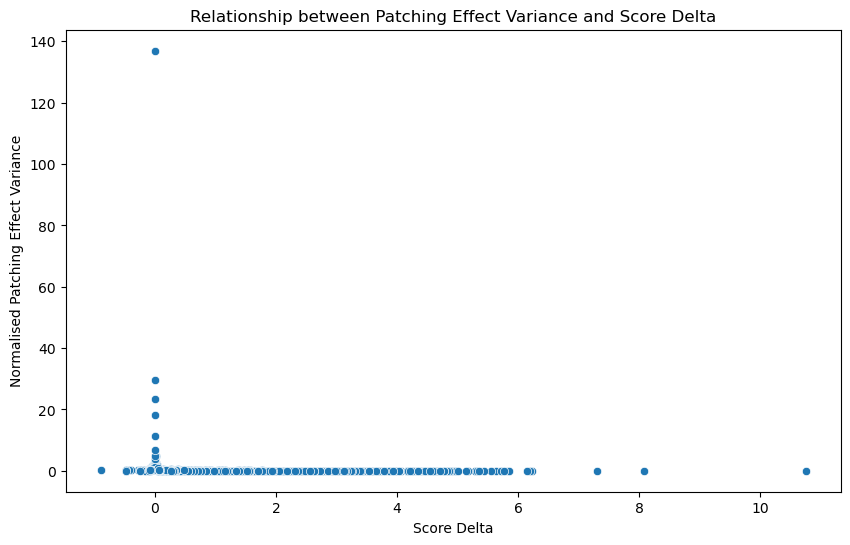

In [ ]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_std', x='score_delta')
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

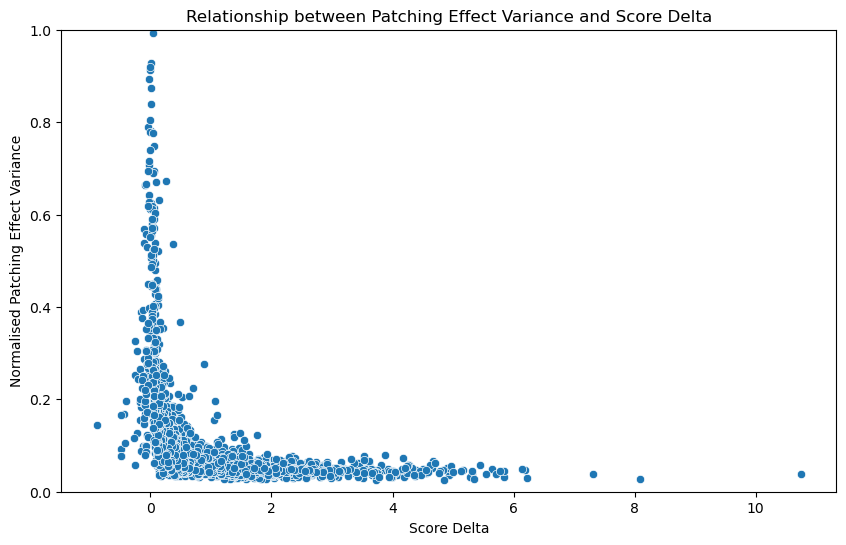

In [17]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_normalised_std', x='score_delta')
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.ylim(0,1)
plt.show()

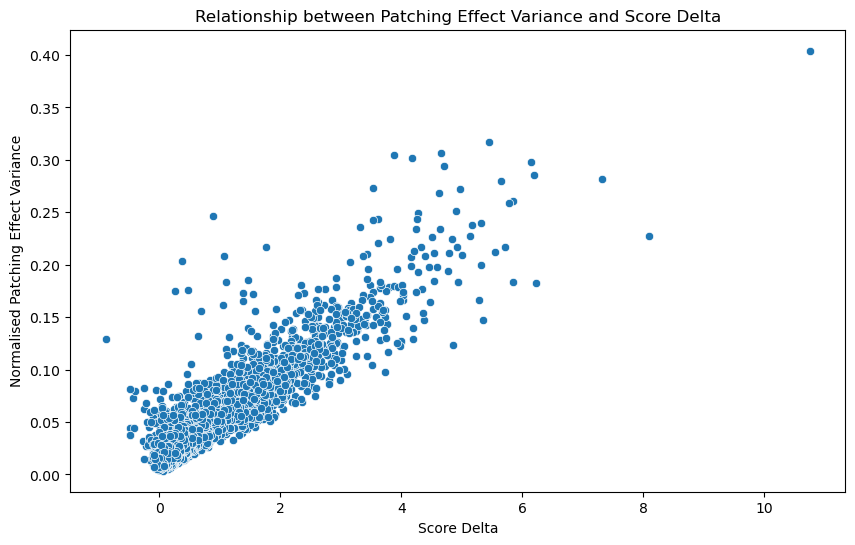

In [22]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_std', x='score_delta')
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

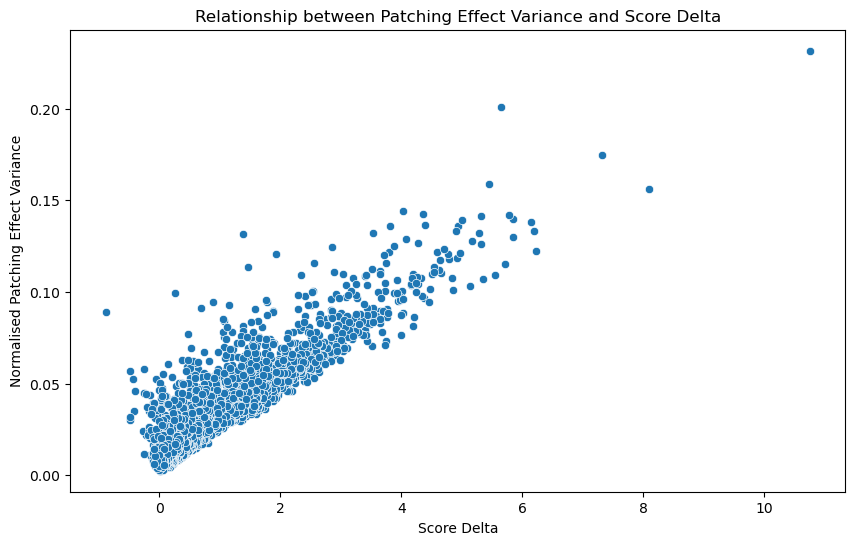

In [23]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean', x='score_delta')
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

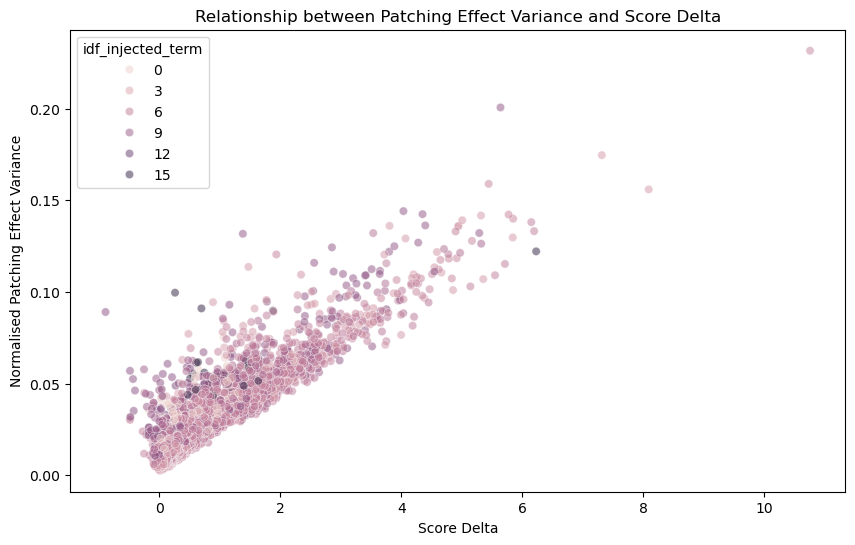

In [37]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean', x='score_delta', hue='idf_injected_term', alpha=0.5)
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

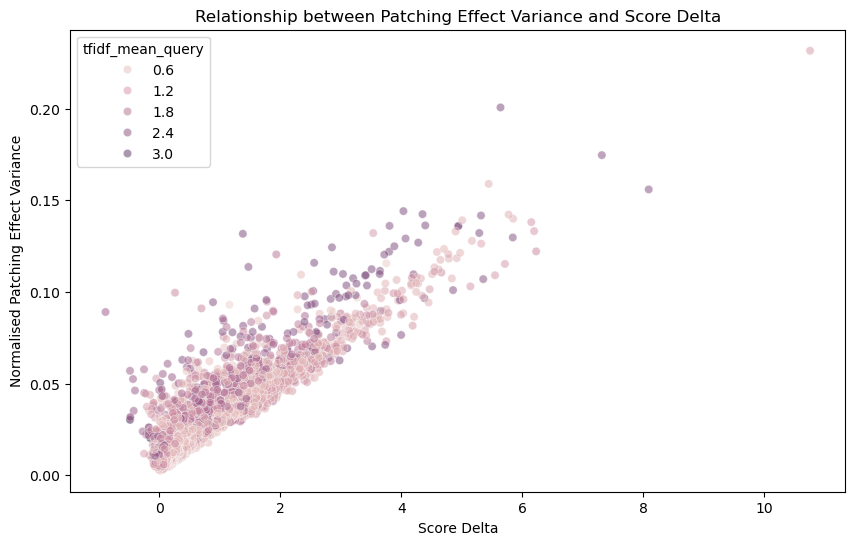

In [47]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean', x='score_delta', hue='tfidf_mean_query', alpha=0.5)
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

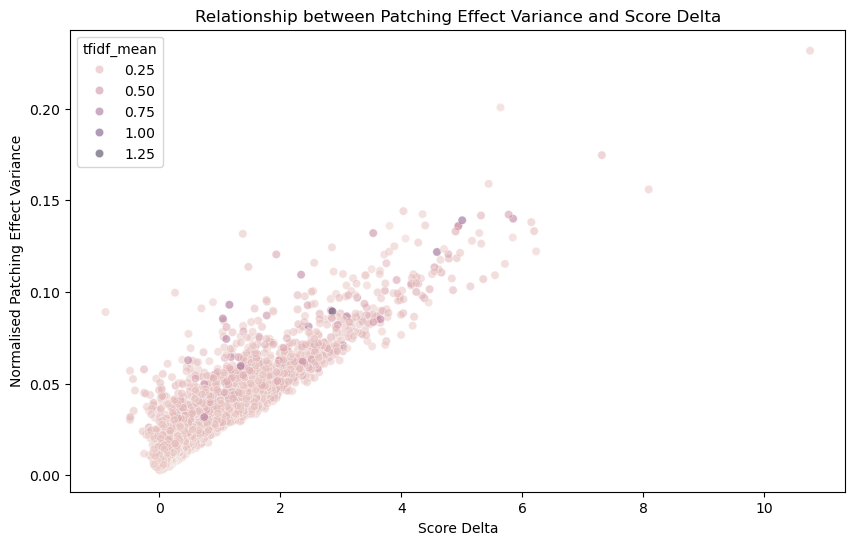

In [48]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean', x='score_delta', hue='tfidf_mean', alpha=0.5)
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

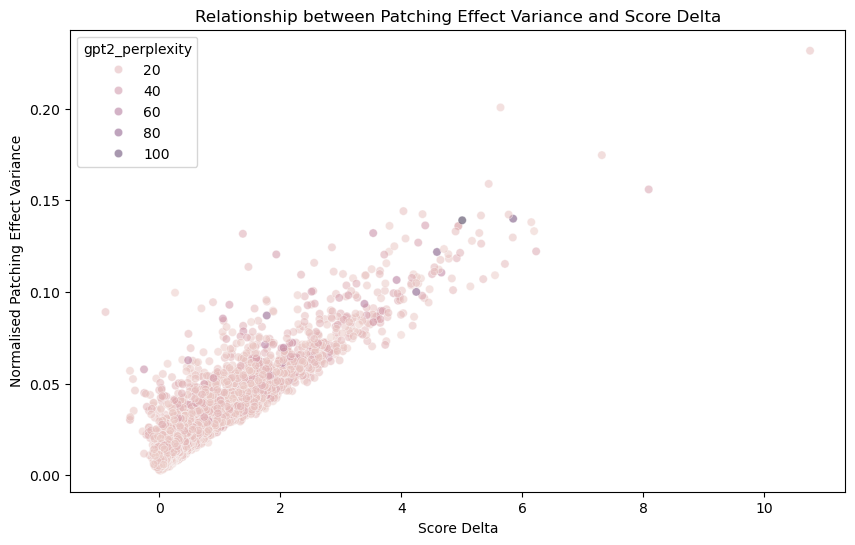

In [49]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean', x='score_delta', hue='gpt2_perplexity', alpha=0.5)
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

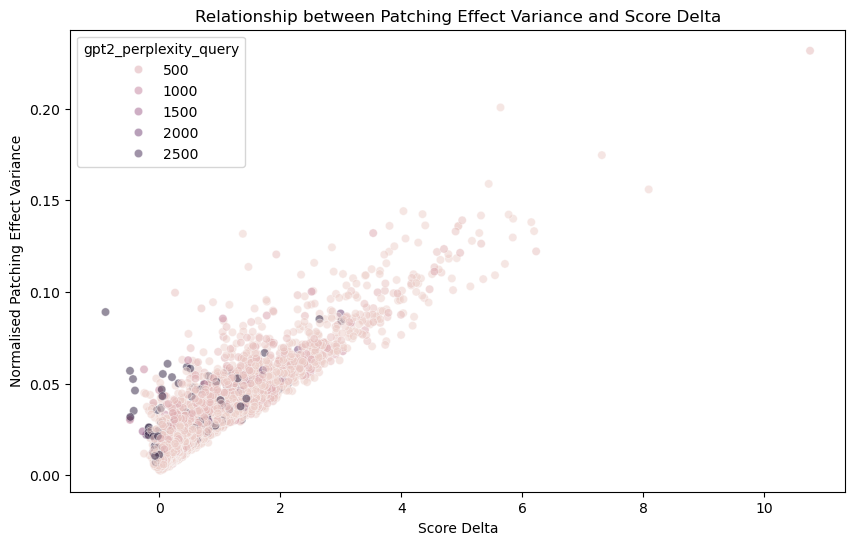

In [51]:
plt.figure(figsize=(10, 6))
scatter_plot = sns.scatterplot(data=all_data_pd, y='patching_effect_absolute_mean', x='score_delta', hue='gpt2_perplexity_query', alpha=0.5)
plt.xlabel('Score Delta')
plt.ylabel('Normalised Patching Effect Variance')
plt.title('Relationship between Patching Effect Variance and Score Delta')
plt.show()

In [41]:
def output_partial_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            if property != 'score_delta':
                spearman_partial = partial_corr(data=all_data_pd, x=target_metric, y=property, covar='score_delta', method='spearman')
                correlations[target_metric][property] = {'spearman_partial': np.round(spearman_partial['r'].values[0], 3), 
                                                        'p-value': np.round(spearman_partial['p-val'].values[0], 3)}
    return pd.DataFrame(correlations)


target_metrics = ['patching_effect_std', 'patching_effect_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
correlations_table.rename(columns={'patching_effect_std': 'Std of Unnormalised Patching Effect',
                                   'patching_effect_absolute_mean': 'Mean Absolute Unnormalosed Patching effect'}, inplace=True)
correlations_table = correlations_table.sort_values(by='Std of Unnormalised Patching Effect', key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/home/scratch_local/esx208-1107593/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/scratch_local/esx208-1107593/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix
/home/scratch_local/esx208-1107593/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/scratch_local/esx208-1107593/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [42]:
correlations_table

,Std of Unnormalised Patching Effect,Mean Absolute Unnormalosed Patching effect
tfidf_mean_query,"{'spearman_partial': 0.228, 'p-value': 0.0}","{'spearman_partial': 0.254, 'p-value': 0.0}"
tfidf_mean,"{'spearman_partial': 0.216, 'p-value': 0.0}","{'spearman_partial': 0.268, 'p-value': 0.0}"
idf_injected_term,"{'spearman_partial': 0.169, 'p-value': 0.0}","{'spearman_partial': 0.191, 'p-value': 0.0}"
dale_chall_readability_score_query,"{'spearman_partial': 0.169, 'p-value': 0.0}","{'spearman_partial': 0.198, 'p-value': 0.0}"
smog_index,"{'spearman_partial': -0.167, 'p-value': 0.0}","{'spearman_partial': -0.219, 'p-value': 0.0}"
gpt2_perplexity_query,"{'spearman_partial': 0.16, 'p-value': 0.0}","{'spearman_partial': 0.148, 'p-value': 0.0}"
flesch_reading_ease_query,"{'spearman_partial': -0.156, 'p-value': 0.0}","{'spearman_partial': -0.177, 'p-value': 0.0}"
tfidf_std_query,"{'spearman_partial': 0.154, 'p-value': 0.0}","{'spearman_partial': 0.141, 'p-value': 0.0}"
automated_readability_index_query,"{'spearman_partial': 0.152, 'p-value': 0.0}","{'spearman_partial': 0.178, 'p-value': 0.0}"
gpt2_perplexity,"{'spearman_partial': 0.136, 'p-value': 0.0}","{'spearman_partial': 0.175, 'p-value': 0.0}"


In [44]:
def output_partial_correlations(properties, target_metrics, data):
    correlations = dict()
    for target_metric in target_metrics:
        correlations[target_metric] = dict()
        for property in properties:
            if property != 'score_delta':
                spearman_partial = partial_corr(data=all_data_pd, x=target_metric, y=property, covar='score_delta', method='spearman')
                correlations[target_metric][property] = {'spearman_partial': np.round(spearman_partial['r'].values[0], 3), 
                                                        'p-value': np.round(spearman_partial['p-val'].values[0], 3)}
    return pd.DataFrame(correlations)


target_metrics = ['patching_effect_normalised_square_std', 'patching_effect_normalised_square_absolute_mean']

properties = ['score_delta', 'relevance', 'tfidf_injected_term', 'idf_injected_term', 'tf_injected_term', 'tfidf_mean', 'tfidf_std', 'english_probability', 'flesch_reading_ease', 'gunning_fog', 
              'smog_index', 'coleman_liau_index', 'automated_readability_index', 'dale_chall_readability_score', 'gpt2_perplexity', 
              'tfidf_mean_query', 'tfidf_std_query', 'english_probability_query', 'flesch_reading_ease_query', 'gunning_fog_query', 
              'smog_index_query', 'coleman_liau_index_query', 'automated_readability_index_query', 'dale_chall_readability_score_query','gpt2_perplexity_query']
correlations_table = output_partial_correlations(properties, target_metrics, all_data_pd)
correlations_table.rename(columns={'patching_effect_normalised_square_std': 'Std of Patching Effect (w/ Penalty)',
                                    'patching_effect_normalised_square_absolute_mean': 'Mean Absolute Patching effect (w/ Penalty)'}, inplace=True)
correlations_table = correlations_table.sort_values(by='Std of Patching Effect (w/ Penalty)', key=lambda x: x.apply(lambda y: -np.abs(y['spearman_partial'])))

/home/scratch_local/esx208-1107593/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:866: RuntimeWarning: divide by zero encountered in divide
  D = np.diag(np.sqrt(1 / Vi_diag))
/home/scratch_local/esx208-1107593/ir_mech_interp/lib/python3.9/site-packages/pingouin/correlation.py:867: RuntimeWarning: invalid value encountered in matmul
  pcor = -1 * (D @ Vi @ D)  # Partial correlation matrix


In [45]:
correlations_table

,Std of Patching Effect (w/ Penalty),Mean Absolute Patching effect (w/ Penalty)
smog_index_query,"{'spearman_partial': -0.892, 'p-value': 0.0}","{'spearman_partial': nan, 'p-value': nan}"
tfidf_mean,"{'spearman_partial': 0.2, 'p-value': 0.0}","{'spearman_partial': 0.248, 'p-value': 0.0}"
tfidf_mean_query,"{'spearman_partial': 0.16, 'p-value': 0.0}","{'spearman_partial': 0.203, 'p-value': 0.0}"
idf_injected_term,"{'spearman_partial': 0.152, 'p-value': 0.0}","{'spearman_partial': 0.193, 'p-value': 0.0}"
smog_index,"{'spearman_partial': -0.148, 'p-value': 0.0}","{'spearman_partial': -0.207, 'p-value': 0.0}"
gpt2_perplexity_query,"{'spearman_partial': 0.145, 'p-value': 0.0}","{'spearman_partial': 0.124, 'p-value': 0.0}"
flesch_reading_ease_query,"{'spearman_partial': -0.139, 'p-value': 0.0}","{'spearman_partial': -0.192, 'p-value': 0.0}"
automated_readability_index_query,"{'spearman_partial': 0.136, 'p-value': 0.0}","{'spearman_partial': 0.198, 'p-value': 0.0}"
coleman_liau_index_query,"{'spearman_partial': 0.135, 'p-value': 0.0}","{'spearman_partial': 0.192, 'p-value': 0.0}"
dale_chall_readability_score,"{'spearman_partial': 0.135, 'p-value': 0.0}","{'spearman_partial': 0.187, 'p-value': 0.0}"


In [27]:
def train_catboost_model(df, target_column, feature_columns):
    X = df[feature_columns]
    y = df[target_column]
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )
    
    model = CatBoostRegressor(
        iterations=1000,
        learning_rate=0.1,
        depth=6,
        loss_function='RMSE',
        eval_metric='RMSE',
        random_seed=42,
        early_stopping_rounds=20,
        verbose=100
    )
    
    model.fit(
        X_train, y_train,
        eval_set=(X_test, y_test),
        plot=True
    )
    
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    
    feature_importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    return {
        'model': model,
        'rmse': rmse,
        'r2': r2,
        'feature_importance': feature_importance,
        'predictions': y_pred
    }

In [32]:
results = train_catboost_model(all_data_pd, 'patching_effect_normalised_square_std', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0140165	test: 0.0144484	best: 0.0144484 (0)	total: 2.44ms	remaining: 2.44s
100:	learn: 0.0070941	test: 0.0087813	best: 0.0087813 (100)	total: 195ms	remaining: 1.73s
200:	learn: 0.0057313	test: 0.0083601	best: 0.0083573 (198)	total: 389ms	remaining: 1.54s
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.008289841837
bestIteration = 268

Shrink model to first 269 iterations.


In [33]:
results

{'model': <catboost.core.CatBoostRegressor at 0x7f04a9737640>,
 'rmse': 0.008289841836804214,
 'r2': 0.6939290726959566,
 'feature_importance':                                feature  importance
 0                          score_delta   26.201951
 3                    idf_injected_term   16.669251
 16                     tfidf_std_query    8.971167
 1                            relevance    5.478401
 5                           tfidf_mean    5.294186
 15                    tfidf_mean_query    4.579637
 6                            tfidf_std    4.077529
 14                     gpt2_perplexity    3.200964
 17           english_probability_query    3.117176
 24               gpt2_perplexity_query    2.700925
 10                          smog_index    2.100005
 19                   gunning_fog_query    1.911846
 21            coleman_liau_index_query    1.907543
 18           flesch_reading_ease_query    1.857572
 9                          gunning_fog    1.719305
 22   automated_readabili

In [34]:
results = train_catboost_model(all_data_pd, 'patching_effect_normalised_square_absolute_mean', properties)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.0080379	test: 0.0085991	best: 0.0085991 (0)	total: 4.29ms	remaining: 4.29s
100:	learn: 0.0041781	test: 0.0053646	best: 0.0053646 (100)	total: 207ms	remaining: 1.84s
200:	learn: 0.0033216	test: 0.0050841	best: 0.0050839 (199)	total: 385ms	remaining: 1.53s
300:	learn: 0.0028144	test: 0.0049937	best: 0.0049937 (300)	total: 587ms	remaining: 1.36s
400:	learn: 0.0024382	test: 0.0049622	best: 0.0049611 (399)	total: 794ms	remaining: 1.19s
500:	learn: 0.0021473	test: 0.0049359	best: 0.0049323 (488)	total: 1s	remaining: 999ms
Stopped by overfitting detector  (20 iterations wait)

bestTest = 0.004925189612
bestIteration = 518

Shrink model to first 519 iterations.


In [35]:
results

{'model': <catboost.core.CatBoostRegressor at 0x7f04a9705e20>,
 'rmse': 0.00492518961214684,
 'r2': 0.6939577935254273,
 'feature_importance':                                feature  importance
 0                          score_delta   21.784287
 3                    idf_injected_term   17.986013
 5                           tfidf_mean    7.593705
 16                     tfidf_std_query    5.625132
 14                     gpt2_perplexity    4.683541
 15                    tfidf_mean_query    4.456573
 1                            relevance    3.557531
 24               gpt2_perplexity_query    3.496818
 10                          smog_index    3.450240
 6                            tfidf_std    3.087771
 18           flesch_reading_ease_query    2.927445
 22   automated_readability_index_query    2.511187
 13        dale_chall_readability_score    2.450933
 17           english_probability_query    2.361944
 19                   gunning_fog_query    2.358436
 8                  flesch